# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

Dataset shape: (976, 11)

Data types:
 Make                 object
Make_Year             int64
Color                object
Body_Type            object
Mileage_Run           int64
No_of_Owners         object
Seating_Capacity      int64
Fuel_Type            object
Transmission         object
Transmission_Type    object
Price                 int64
dtype: object

Missing values:
 Make                 0
Make_Year            0
Color                0
Body_Type            0
Mileage_Run          0
No_of_Owners         0
Seating_Capacity     0
Fuel_Type            0
Transmission         0
Transmission_Type    0
Price                0
dtype: int64

Descriptive statistics:
            Make    Make_Year  Color  Body_Type   Mileage_Run No_of_Owners  \
count       976   976.000000    976        976    976.000000          976   
unique       16          NaN     15          5           NaN            3   
top     Hyundai          NaN  white  hatchback           NaN          1st   
freq        305      

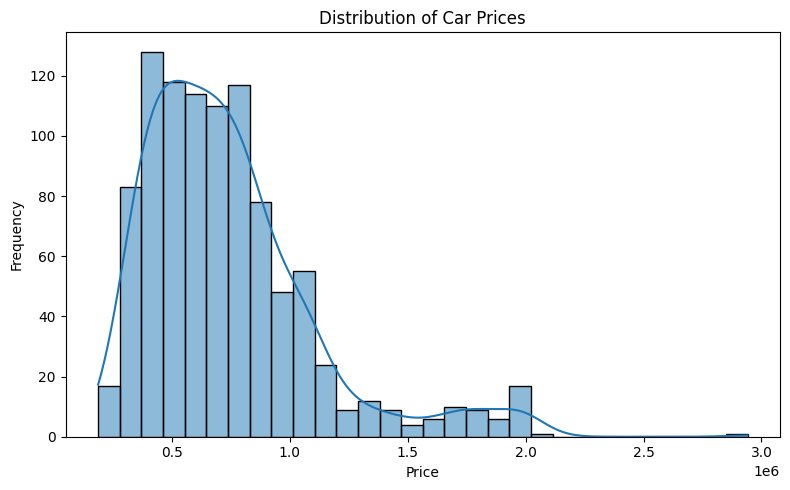

In [3]:
#Question 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cars_df = pd.read_csv('cars_hw.csv')
cars_df.drop(columns=['Unnamed: 0'], inplace=True)

print("Dataset shape:", cars_df.shape)
print("\nData types:\n", cars_df.dtypes)

print("\nMissing values:\n", cars_df.isnull().sum())

print("\nDescriptive statistics:\n", cars_df.describe(include='all'))

plt.figure(figsize=(8, 5))
sns.histplot(cars_df['Price'], bins=30, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [4]:
#Question 2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = cars_df.select_dtypes(include='object').columns.tolist()
numerical_cols = cars_df.select_dtypes(include=np.number).drop(columns='Price').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)


Categorical Columns: ['Make', 'Color', 'Body_Type', 'No_of_Owners', 'Fuel_Type', 'Transmission', 'Transmission_Type']
Numerical Columns: ['Make_Year', 'Mileage_Run', 'Seating_Capacity']


In [5]:
#Question 3
from sklearn.model_selection import train_test_split

X = cars_df.drop(columns='Price')
y = cars_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 780
Test set size: 196


In [8]:
#Question 4
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

simple_model.fit(X_train, y_train)

y_train_pred = simple_model.predict(X_train)
y_test_pred = simple_model.predict(X_test)

rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5
r2_train = r2_score(y_train, y_train_pred)
rmse_test = mean_squared_error(y_test, y_test_pred) ** 0.5
r2_test = r2_score(y_test, y_test_pred)

print("Train RMSE:", rmse_train)
print("Train R²:", r2_train)
print("Test RMSE:", rmse_test)
print("Test R²:", r2_test)


Train RMSE: 150316.87097261433
Train R²: 0.8381210411894562
Test RMSE: 145496.68224910498
Test R²: 0.8154305290120012


So far, we have built a simple linear regression model using one-hot encoded categorical variables and untransformed numerical variables. This model achieved a training R² of 0.838 and a test R² of 0.815, with root mean squared errors (RMSE) of approximately 150,317 on the training set and 145,497 on the test set. These results indicate that the model fits the training data well and generalizes effectively to unseen data. Therefore, based on its high R² values and low RMSE, this simple linear model performs well and is currently the best among the models we've built.

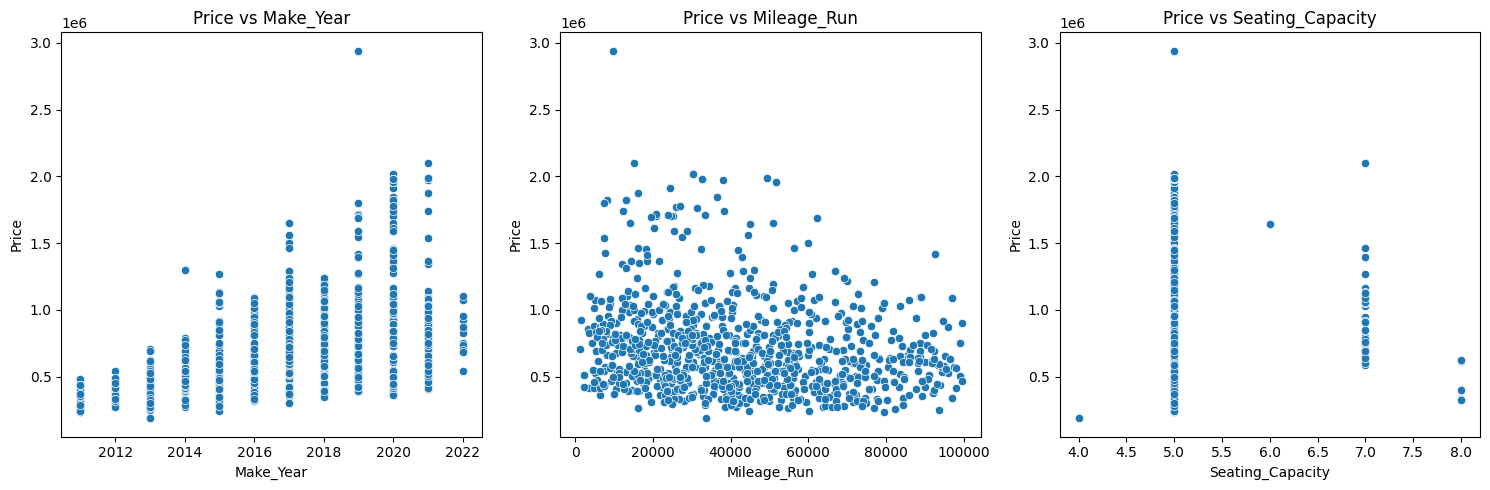

Make_Year           0.528225
Mileage_Run        -0.169715
Seating_Capacity    0.071999
Name: Price, dtype: float64


In [9]:
#Question 5
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, len(numerical_cols))

for i, col in enumerate(numerical_cols):
    ax = plt.subplot(gs[0, i])
    sns.scatterplot(data=cars_df, x=col, y='Price', ax=ax)
    ax.set_title(f'Price vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()

correlations = cars_df[numerical_cols + ['Price']].corr()['Price'].drop('Price')
print(correlations)


Yes, there are signs of non-linear relationships in the data. For instance, the scatter plot between Mileage_Run and Price suggests a slightly curved, inverse relationship—indicating that cars with higher mileage tend to be cheaper, but the rate of depreciation may not be strictly linear. On the other hand, Make_Year has a fairly linear positive relationship with price, while Seating_Capacity shows no strong relationship at all, likely because most values are clustered around five. Overall, the most noticeable non-linearity appears in the mileage variable, which could benefit from transformation or interaction terms in a more complex model.

In [10]:
#Question 6
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

complex_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('regressor', LinearRegression())
])

complex_model.fit(X_train, y_train)

y_train_pred_complex = complex_model.predict(X_train)
y_test_pred_complex = complex_model.predict(X_test)

rmse_train_complex = mean_squared_error(y_train, y_train_pred_complex) ** 0.5
r2_train_complex = r2_score(y_train, y_train_pred_complex)

rmse_test_complex = mean_squared_error(y_test, y_test_pred_complex) ** 0.5
r2_test_complex = r2_score(y_test, y_test_pred_complex)

print("Train RMSE (Complex Model):", rmse_train_complex)
print("Train R² (Complex Model):", r2_train_complex)
print("Test RMSE (Complex Model):", rmse_test_complex)
print("Test R² (Complex Model):", r2_test_complex)


Train RMSE (Complex Model): 169573.5567825569
Train R² (Complex Model): 0.7939886216628768
Test RMSE (Complex Model): 169555.07277597362
Test R² (Complex Model): 0.7493456406823646


The more complex model, which included interaction terms using polynomial features, performed worse than the simpler linear regression model. While it was designed to capture more nuanced relationships between variables, it actually resulted in lower R² values and higher root mean squared errors (RMSE) on both the training and test sets. Specifically, the complex model achieved a training R² of 0.794 and a test R² of 0.749, compared to the simpler model’s 0.838 training R² and 0.815 test R². Similarly, its RMSE values were also higher.

These results suggest that the added complexity did not help the model generalize better; instead, it introduced noise and overfit the training data. In contrast, the simpler model struck a better balance between underfitting and overfitting, making it the preferred choice for this dataset.

Question 7: From Steps 1 to 6, I was able to walk through the full modeling process and observe how model complexity impacts performance. In Step 1, I explored a clean dataset of 976 used cars, with no missing values and a reasonable mix of categorical and numerical variables. Most cars were priced between 400,000 and 1,000,000, and the target variable (price) had a right-skewed distribution.

In Step 2, I prepared the data for regression by one-hot encoding the categorical variables and leaving the numeric ones as-is. This transformation allowed the linear regression model to process all variables correctly. Then, in Step 3, I split the data into training and test sets, ensuring that model performance could be fairly evaluated on unseen data.

In Step 4, I trained a simple linear regression model. The model performed well, with an R² of 0.838 on the training set and 0.815 on the test set. This indicated that the model captured the core patterns in the data without overfitting. In Step 5, I examined scatter plots for the numerical variables. Make_Year showed a clear positive linear relationship with price, while Mileage_Run had a weak negative association. These visualizations suggested that linear modeling was generally appropriate, although mileage may have a slightly non-linear effect.

In Step 6, I built a more complex model by introducing interaction terms. However, the model’s performance declined—its test R² dropped to 0.749 and the RMSE increased. This suggests that the added complexity did not help and may have caused overfitting, as the model captured noise instead of meaningful patterns.

Through this process, I learned an important lesson about model selection: more complex models are not always better. Although adding interaction terms can capture richer relationships, they can also introduce noise if not carefully validated. The simple linear model ended up performing best, balancing bias and variance effectively. This experience highlighted the importance of evaluating models not just on training performance, but also on their ability to generalize to new data.